In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/My\ Drive/BTP/ImageQuilting

/content/drive/My Drive/BTP/ImageQuilting


In [ ]:
pwd

'/content/drive/My Drive/BTP/ImageQuilting'

In [ ]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from math import ceil
from itertools import product

inf = np.float('inf')
ErrorCombinationFunc = np.add


def findPatchHorizontal(refBlock, texture, blocksize, overlap, tolerance):
	'''
	Find best horizontal match from the texture
	'''
	errMat_lst=[]
	
	for k in range(len(texture)):
			H, W = texture[k].shape[:2]
			errMat = np.zeros((H-blocksize, W-blocksize)) + inf
			for i, j in product(range(H-blocksize), range(W-blocksize)):
				rmsVal = ((texture[k][i:i+blocksize, j:j+overlap] - refBlock[:, -overlap:])**2).mean()
				if rmsVal > 0:
					errMat[i, j] = rmsVal
			errMat_lst.append(errMat)

	minVal = np.min(errMat_lst[0])
	ind=0
	for k in range(1,len(texture)):
		temp = np.min(errMat_lst[1])
		if(temp<minVal):
			minVal = temp
			ind = k
	y, x = np.where(errMat_lst[ind] < (1.0 + tolerance)*(minVal))
	c = np.random.randint(len(y))
	y, x = y[c], x[c]
	return texture[ind][y:y+blocksize, x:x+blocksize]


def findPatchBoth(refBlockLeft, refBlockTop, texture, blocksize, overlap, tolerance):
	'''
	Find best horizontal and vertical match from the texture
	'''
	errMat_lst=[]
	for k in range(len(texture)):
			
			H, W = texture[k].shape[:2]
			errMat = np.zeros((H-blocksize, W-blocksize)) + inf
			
			for i, j in product(range(H-blocksize), range(W-blocksize)):
				rmsVal = ((texture[k][i:i+overlap, j:j+blocksize] - refBlockTop[-overlap:, :])**2).mean()
				rmsVal = rmsVal + ((texture[k][i:i+blocksize, j:j+overlap] - refBlockLeft[:, -overlap:])**2).mean()
				if rmsVal > 0:
					errMat[i, j] = rmsVal
			errMat_lst.append(errMat)

	minVal = np.min(errMat_lst[0])
	ind=0
	for k in range(1,len(texture)):
		temp = np.min(errMat_lst[1])
		if(temp<minVal):
			minVal = temp
			ind = k
	y, x = np.where(errMat_lst[ind] < (1.0 + tolerance)*(minVal))
	c = np.random.randint(len(y))
	y, x = y[c], x[c]
	return texture[ind][y:y+blocksize, x:x+blocksize]


def findPatchVertical(refBlock, texture, blocksize, overlap, tolerance):
	'''
	Find best vertical match from the texture
	'''
	errMat_lst=[]
	
	for k in range(len(texture)):
			H, W = texture[k].shape[:2]
			errMat = np.zeros((H-blocksize, W-blocksize)) + inf
			for i, j in product(range(H-blocksize), range(W-blocksize)):
				rmsVal = ((texture[k][i:i+overlap, j:j+blocksize] - refBlock[-overlap:, :])**2).mean()
				if rmsVal > 0:
					errMat[i, j] = rmsVal
			errMat_lst.append(errMat)

	minVal = np.min(errMat_lst[0])
	ind=0
	for k in range(1,len(texture)):
		temp = np.min(errMat_lst[1])
		if(temp<minVal):
			minVal = temp
			ind = k
	y, x = np.where(errMat_lst[ind] < (1.0 + tolerance)*(minVal))
	c = np.random.randint(len(y))
	y, x = y[c], x[c]
	return texture[ind][y:y+blocksize, x:x+blocksize]


def getMinCutPatchHorizontal(block1, block2, blocksize, overlap):
	'''
	Get the min cut patch done horizontally
	'''
	err = ((block1[:, -overlap:] - block2[:, :overlap])**2).mean(2)
	# maintain minIndex for 2nd row onwards and 
	minIndex = []
	E = [list(err[0])]
	for i in range(1, err.shape[0]):
		# Get min values and args, -1 = left, 0 = middle, 1 = right
		e = [inf] + E[-1] + [inf]
		e = np.array([e[:-2], e[1:-1], e[2:]])
		# Get minIndex
		minArr = e.min(0)
		minArg = e.argmin(0) - 1
		minIndex.append(minArg)
		# Set Eij = e_ij + min_
		Eij = err[i] + minArr
		E.append(list(Eij))

	# Check the last element and backtrack to find path
	path = []
	minArg = np.argmin(E[-1])
	path.append(minArg)

	# Backtrack to min path
	for idx in minIndex[::-1]:
		minArg = minArg + idx[minArg]
		path.append(minArg)
	# Reverse to find full path
	path = path[::-1]
	mask = np.zeros((blocksize, blocksize, block1.shape[2]))
	for i in range(len(path)):
		mask[i, :path[i]+1] = 1

	resBlock = np.zeros(block1.shape)
	resBlock[:, :overlap] = block1[:, -overlap:]
	resBlock = resBlock*mask + block2*(1-mask)
	# resBlock = block1*mask + block2*(1-mask)
	return resBlock


def getMinCutPatchVertical(block1, block2, blocksize, overlap):
	'''
	Get the min cut patch done vertically
	'''
	resBlock = getMinCutPatchHorizontal(np.rot90(block1), np.rot90(block2), blocksize, overlap)
	return np.rot90(resBlock, 3)


def getMinCutPatchBoth(refBlockLeft, refBlockTop, patchBlock, blocksize, overlap):
	'''
	Find minCut for both and calculate
	'''
	err = ((refBlockLeft[:, -overlap:] - patchBlock[:, :overlap])**2).mean(2)
	# maintain minIndex for 2nd row onwards and 
	minIndex = []
	E = [list(err[0])]
	for i in range(1, err.shape[0]):
		# Get min values and args, -1 = left, 0 = middle, 1 = right
		e = [inf] + E[-1] + [inf]
		e = np.array([e[:-2], e[1:-1], e[2:]])
		# Get minIndex
		minArr = e.min(0)
		minArg = e.argmin(0) - 1
		minIndex.append(minArg)
		# Set Eij = e_ij + min_
		Eij = err[i] + minArr
		E.append(list(Eij))

	# Check the last element and backtrack to find path
	path = []
	minArg = np.argmin(E[-1])
	path.append(minArg)

	# Backtrack to min path
	for idx in minIndex[::-1]:
		minArg = minArg + idx[minArg]
		path.append(minArg)
	# Reverse to find full path
	path = path[::-1]
	mask1 = np.zeros((blocksize, blocksize, patchBlock.shape[2]))
	for i in range(len(path)):
		mask1[i, :path[i]+1] = 1

	###################################################################
	## Now for vertical one
	err = ((np.rot90(refBlockTop)[:, -overlap:] - np.rot90(patchBlock)[:, :overlap])**2).mean(2)
	# maintain minIndex for 2nd row onwards and 
	minIndex = []
	E = [list(err[0])]
	for i in range(1, err.shape[0]):
		# Get min values and args, -1 = left, 0 = middle, 1 = right
		e = [inf] + E[-1] + [inf]
		e = np.array([e[:-2], e[1:-1], e[2:]])
		# Get minIndex
		minArr = e.min(0)
		minArg = e.argmin(0) - 1
		minIndex.append(minArg)
		# Set Eij = e_ij + min_
		Eij = err[i] + minArr
		E.append(list(Eij))

	# Check the last element and backtrack to find path
	path = []
	minArg = np.argmin(E[-1])
	path.append(minArg)

	# Backtrack to min path
	for idx in minIndex[::-1]:
		minArg = minArg + idx[minArg]
		path.append(minArg)
	# Reverse to find full path
	path = path[::-1]
	mask2 = np.zeros((blocksize, blocksize, patchBlock.shape[2]))
	for i in range(len(path)):
		mask2[i, :path[i]+1] = 1
	mask2 = np.rot90(mask2, 3)


	mask2[:overlap, :overlap] = np.maximum(mask2[:overlap, :overlap] - mask1[:overlap, :overlap], 0)

	# Put first mask
	resBlock = np.zeros(patchBlock.shape)
	resBlock[:, :overlap] = mask1[:, :overlap]*refBlockLeft[:, -overlap:]
	resBlock[:overlap, :] = resBlock[:overlap, :] + mask2[:overlap, :]*refBlockTop[-overlap:, :]
	resBlock = resBlock + (1-np.maximum(mask1, mask2))*patchBlock
	return resBlock




def generateTextureMap(image, blocksize, overlap, outH, outW, tolerance):
	nH = int(ceil((outH - blocksize)*1.0/(blocksize - overlap)))
	nW = int(ceil((outW - blocksize)*1.0/(blocksize - overlap)))

	textureMap = np.zeros(((blocksize + nH*(blocksize - overlap)), (blocksize + nW*(blocksize - overlap)), image[0].shape[2]))
	
	# Starting index and block
	H, W = image[0].shape[:2]
	randH = np.random.randint(H - blocksize)
	randW = np.random.randint(W - blocksize)

	startBlock = image[0][randH:randH+blocksize, randW:randW+blocksize]
	textureMap[:blocksize, :blocksize, :] = startBlock

	# Fill the first row 
	for i, blkIdx in enumerate(range((blocksize-overlap), textureMap.shape[1]-overlap, (blocksize-overlap))):
		# Find horizontal error for this block
		# Calculate min, find index having tolerance
		# Choose one randomly among them
		# blkIdx = block index to put in
		refBlock = textureMap[:blocksize, (blkIdx-blocksize+overlap):(blkIdx+overlap)]
		patchBlock = findPatchHorizontal(refBlock, image, blocksize, overlap, tolerance)
		minCutPatch = getMinCutPatchHorizontal(refBlock, patchBlock, blocksize, overlap)
		textureMap[:blocksize, (blkIdx):(blkIdx+blocksize)] = minCutPatch
	print("{} out of {} rows complete...".format(1, nH+1))


	### Fill the first column
	for i, blkIdx in enumerate(range((blocksize-overlap), textureMap.shape[0]-overlap, (blocksize-overlap))):
		# Find vertical error for this block
		# Calculate min, find index having tolerance
		# Choose one randomly among them
		# blkIdx = block index to put in
		refBlock = textureMap[(blkIdx-blocksize+overlap):(blkIdx+overlap), :blocksize]
		patchBlock = findPatchVertical(refBlock, image, blocksize, overlap, tolerance)
		minCutPatch = getMinCutPatchVertical(refBlock, patchBlock, blocksize, overlap)

		textureMap[(blkIdx):(blkIdx+blocksize), :blocksize] = minCutPatch

	### Fill in the other rows and columns
	for i in range(1, nH+1):
		for j in range(1, nW+1):
			# Choose the starting index for the texture placement
			blkIndexI = i*(blocksize-overlap)
			blkIndexJ = j*(blocksize-overlap)
			# Find the left and top block, and the min errors independently
			refBlockLeft = textureMap[(blkIndexI):(blkIndexI+blocksize), (blkIndexJ-blocksize+overlap):(blkIndexJ+overlap)]
			refBlockTop  = textureMap[(blkIndexI-blocksize+overlap):(blkIndexI+overlap), (blkIndexJ):(blkIndexJ+blocksize)]

			patchBlock = findPatchBoth(refBlockLeft, refBlockTop, image, blocksize, overlap, tolerance)
			minCutPatch = getMinCutPatchBoth(refBlockLeft, refBlockTop, patchBlock, blocksize, overlap) 

			textureMap[(blkIndexI):(blkIndexI+blocksize), (blkIndexJ):(blkIndexJ+blocksize)] = minCutPatch

			# refBlockLeft = 0.5
			# textureMap[(blkIndexI):(blkIndexI+blocksize), (blkIndexJ-blocksize+overlap):(blkIndexJ+overlap)] = refBlockLeft
			# textureMap[(blkIndexI-blocksize+overlap):(blkIndexI+overlap), (blkIndexJ):(blkIndexJ+blocksize)] = [0.5, 0.6, 0.7]
			# break
		print("{} out of {} rows complete...".format(i+1, nH+1))
		# break

	return textureMap


Image size: (246, 253)
Image size: (267, 264)
Image size: (258, 206)
Image size: (207, 262)
Image size: (250, 256)
Image size: (255, 253)
Image size: (253, 249)
Image size: (242, 252)
1 out of 16 rows complete...
2 out of 16 rows complete...
3 out of 16 rows complete...
4 out of 16 rows complete...
5 out of 16 rows complete...
6 out of 16 rows complete...
7 out of 16 rows complete...
8 out of 16 rows complete...
9 out of 16 rows complete...
10 out of 16 rows complete...
11 out of 16 rows complete...
12 out of 16 rows complete...
13 out of 16 rows complete...
14 out of 16 rows complete...
15 out of 16 rows complete...
16 out of 16 rows complete...


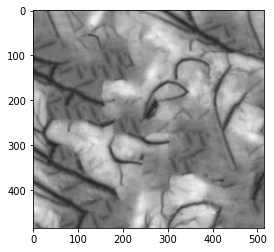

Saved output to grayscale_patches/output_8.png


In [7]:
import os
import numpy as np
import argparse
import cv2
from matplotlib import pyplot as plt
# from utils.preprocess import *
# from utils.generate import *
from math import ceil

## Get parser arguments
# parser = argparse.ArgumentParser()
# parser.add_argument("-i", "--image_path", required=True, type=str, help="path of image you want to quilt")
# parser.add_argument("-b", "--block_size", type=int, default=20, help="block size in pixels")
# parser.add_argument("-o", "--overlap", type=int, default=1.0/6, help="overlap size in pixels (defaults to 1/6th of block size)")
# parser.add_argument("-s", "--scale", type=float, default=2, help="Scaling w.r.t. to image size")
# parser.add_argument("-n", "--num_outputs", type=int, default=1, help="number of output textures required")
# parser.add_argument("-f", "--output_file", type=str, default="output.png", help="output file name")
# parser.add_argument("-p", "--plot", type=int, default=1, help="Show plots")
# parser.add_argument("-t", "--tolerance", type=float, default=0.1, help="Tolerance fraction")

# args = parser.parse_args()
num_outputs = 1

tolerance = 0.1
plot = 1
numImages = 8
if __name__ == "__main__":
	# Start the main loop here
	path = 'patch_.jpeg'
	block_size = 35
	scale = 2
  
	overlap = 1.0/6
	# print("Using plot {}".format(args.plot))
	# Set overlap to 1/6th of block size
	if overlap > 0:
		overlap = int(block_size*overlap)
	else:
		overlap = int(block_size/6.0)

	# Get all blocks
	image=[]
	for i in range(numImages):
		output_file = "grayscale_patches/output_{}.png".format(i+1)
		image1 = cv2.imread("grayscale_patches/{}.png".format(i+1))
		image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)/255.0
		print("Image size: ({}, {})".format(*image1.shape[:2]))
		image.append(image1)

	# image1 = cv2.imread('relevant_patches/patch_1.jpeg')
	# image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)/255.0
	# print("Image1 size: ({}, {})".format(*image1.shape[:2]))

	# image2 = cv2.imread('relevant_patches/patch_2.jpeg')
	# image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)/255.0
	# print("Image1 size: ({}, {})".format(*image2.shape[:2]))
 
	# image3 = cv2.imread('relevant_patches/patch_3.jpeg')
	# image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)/255.0
	# print("Image1 size: ({}, {})".format(*image3.shape[:2]))
	# image=[image1, image2, image3]
	# image=[image1]
	H, W = image1.shape[:2]
	outH, outW = int(scale*H), int(scale*W)

	for i in range(num_outputs):
		textureMap = generateTextureMap(image, block_size, overlap, outH, outW, tolerance)
		if plot:
			plt.imshow(textureMap)
			plt.show()

		# Save
		textureMap = (255*textureMap).astype(np.uint8)
		textureMap = cv2.cvtColor(textureMap, cv2.COLOR_RGB2BGR)
		if num_outputs == 1:
			cv2.imwrite(output_file, textureMap)
			print("Saved output to {}".format(output_file))
		else:
			cv2.imwrite(output_file.replace(".", "_{}.".format(i)), textureMap)
			print("Saved output to {}".format(output_file.replace(".", "_{}.".format(i))))